In [ ]:
import pandas as pd
import numpy as np
import os

fp_train = os.path.join('..', 'data', 'train.csv')
fp_test = os.path.join('..', 'data', 'test.csv')

df = pd.read_csv(fp_train)
t_df = pd.read_csv(fp_test)

FileNotFoundError: [Errno 2] No such file or directory: 'data\\train.csv'

## Age Feature Engineering
* mean survival rate is 0.384
* missing age bucket has mean .294
* we should keep this feature then add median.

In [ ]:
# we use new feature array to maintain features we added to the data
n_fea = ['Age_is_missing', 'Deck', 'Title', 'IsAlone']

In [ ]:
# we add age is missing feawture and simply add median to missing value for both df and t_df
for tar in [df, t_df]:
    tar[n_fea[0]] = tar['Age'].isnull().astype(int)
    tar['Age'] = tar['Age'].fillna(tar['Age'].median())

### Cabin
we collect Deck information from Cabin, only the level is useful. and this information should be kept.

In [ ]:
for tar in [df, t_df]:
    tar[n_fea[1]] = tar['Cabin'].str[0]
    tar[n_fea[1]] = tar[n_fea[1]].fillna('U')

### Name
* we Extract title from name, this can be an additional information for age.
* Family information is too discrete and the PClass might be more direct, so we leave it alone. Though Family information seems so attractive at first glance.

In [ ]:
common_titles = ['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev']

for tar in [df, t_df]:
    tar['Title'] = tar['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
    tar['Title'] = tar['Title'].apply(lambda x: x if x in common_titles else 'Other')


### family information
SibSp and Parch: here we take a is_alone from these two information directly

In [ ]:
for tar in [df, t_df]:
    tar['IsAlone'] = ((tar['SibSp'] == 0) & (tar['Parch'] == 0)).astype(int)

### Embarked
* S: Southampton
* C: Cherbourg
* Q: Queenstown

route: 
1. Southampton(England)
2. Cherbourg(France)
3. Queenstown(Ireland)
4. New York(USA)


In [ ]:
for tar in [df, t_df]:
    tar['Embarked'] = tar['Embarked'].fillna('S')

## Model
we just train a classical RandomForest to see the effect of our feature engineering

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Assuming 'df' is your preprocessed training data and 'test_df' is your preprocessed test data.
# Let's combine them before one-hot encoding to ensure consistent columns.
train_index = df.index
test_index = t_df.index
combined_df = pd.concat([df, t_df], ignore_index=True, sort=False)

### One-Hot Encoding
categorical_cols = ['Sex', 'Embarked', 'Deck', 'Title']
combined_encoded = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)

### Re-separating into Training and Test sets
df_encoded = combined_encoded.iloc[train_index]
test_encoded = combined_encoded.iloc[test_index]

### Preparing Data for the Model
# The features for both sets must be the same, so we get the training columns
# and select them from the test set.
features = df_encoded.drop(['Survived', 'Name', 'Ticket', 'Cabin'], axis=1).columns

X = df_encoded[features]
y = df_encoded['Survived']

### Splitting and Training the Model
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.1, random_state=42)
model = RandomForestClassifier(n_estimators=1000, max_depth=3, max_features=5, random_state=42)
model.fit(X_train, y_train)

accuracy = accuracy_score(y_test, model.predict(X_test))
print(f'Model Accuracy with training: {accuracy: .4f}')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
print("CV mean accuracy:", scores.mean())

Model Accuracy with training:  0.7955
CV mean accuracy: 0.8136965664427847


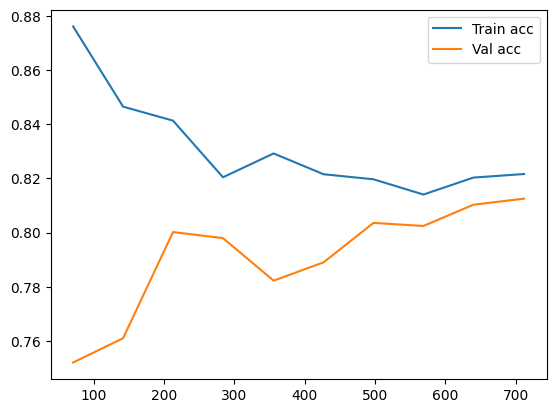

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    model, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Train acc")
plt.plot(train_sizes, val_mean, label="Val acc")
plt.legend()
plt.show()

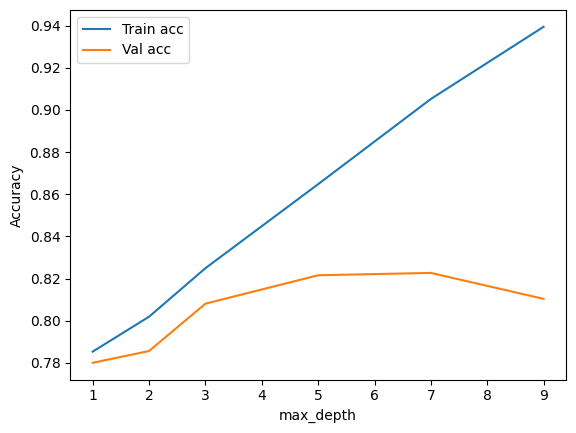

In [ ]:
from sklearn.model_selection import validation_curve

param_range = [1, 2, 3, 5, 7, 9, None]
train_scores, val_scores = validation_curve(
    RandomForestClassifier(n_estimators=200, random_state=42),
    X, y, param_name="max_depth", param_range=param_range, cv=5, scoring="accuracy"
)

plt.plot(param_range, train_scores.mean(axis=1), label="Train acc")
plt.plot(param_range, val_scores.mean(axis=1), label="Val acc")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
### Making and Submitting Predictions
# Select the same features from the test set for prediction
test_features = test_encoded[features]
predictions = model.predict(test_features).astype(int)

# Create the submission file
submission_df = pd.DataFrame({
    'PassengerId': t_df['PassengerId'],
    'Survived': predictions
})

sub_p = os.path.join('submissions', 'fe01.csv')
submission_df.to_csv(sub_p, index=False)

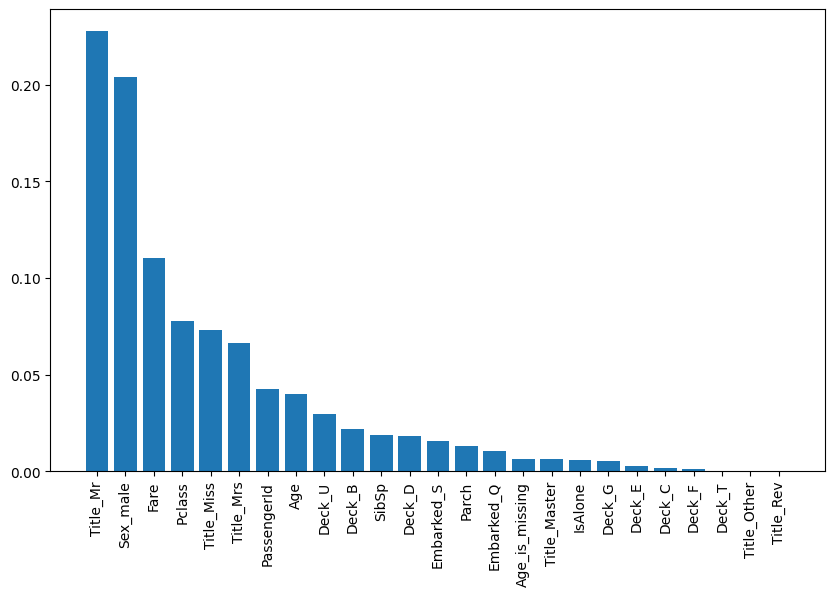

Title_Mr: 0.22773268002165076
Sex_male: 0.20419676358301678
Fare: 0.11020892953056835
Pclass: 0.07787397078682468
Title_Miss: 0.0729835846289829
Title_Mrs: 0.06662084399876923
PassengerId: 0.04239188758864619
Age: 0.04021326680000974
Deck_U: 0.029675391545753476
Deck_B: 0.021643734862535405
SibSp: 0.01900753754820466
Deck_D: 0.01819209320233851
Embarked_S: 0.015500154951680572
Parch: 0.013336539001856378
Embarked_Q: 0.010493243477939037
Age_is_missing: 0.00644244421394576
Title_Master: 0.006208686136169019
IsAlone: 0.006059398751883437
Deck_G: 0.005173970849229274
Deck_E: 0.002635729706678262
Deck_C: 0.001762563464716085
Deck_F: 0.0012551015056031397
Deck_T: 0.0003914838429984947
Title_Other: 0.0
Title_Rev: 0.0


In [ ]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), importances[indices])
plt.xticks(range(len(features)), features[indices], rotation=90)
plt.show()

for i in indices:
    print(f'{features[i]}: {importances[i]}')

In [ ]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=200)
log_model.fit(X_train, y_train)
print("log model Validation accuracy:", log_model.score(X_test, y_test))

### Making and Submitting Predictions
# Select the same features from the test set for prediction
predictions = log_model.predict(test_features).astype(int)

# Create the submission file
submission_df = pd.DataFrame({
    'PassengerId': t_df['PassengerId'],
    'Survived': predictions
})

sub_p = os.path.join('submissions', 'lg01.csv')
submission_df.to_csv(sub_p, index=False)

log model Validation accuracy: 0.7905236907730673


d:\playground\kaggle\Titanic\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scalar = StandardScaler()
X_scaled = scalar.fit_transform(X_train)

log_model = LogisticRegression(max_iter=500)
log_model.fit(X_scaled, y_train)

# Feature importance = absolute value of coefficients
importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": log_model.coef_[0]
}).sort_values(by="Coefficient", key=abs, ascending=False)

print(importance)


           Feature  Coefficient
9       Embarked_Q     1.084932
21        Title_Mr    -1.044207
1           Pclass    -1.026071
8         Sex_male    -0.905080
22       Title_Mrs     0.903173
6   Age_is_missing    -0.819915
11          Deck_B     0.732918
7          IsAlone     0.680757
19    Title_Master     0.652821
0      PassengerId    -0.593425
10      Embarked_S    -0.494097
13          Deck_D     0.484328
20      Title_Miss     0.414351
16          Deck_G    -0.375351
18          Deck_U    -0.300001
2              Age    -0.283248
4            Parch    -0.272848
12          Deck_C    -0.234967
17          Deck_T    -0.208581
14          Deck_E     0.159560
3            SibSp    -0.096025
15          Deck_F    -0.060915
5             Fare    -0.044702
23     Title_Other     0.000000
24       Title_Rev     0.000000
